# Predicting House Prices in Ames, Iowa

#### Data Source: Public dataset from Kaggle https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
#### Author: Emma Ren
#### Date: July 2017



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.decomposition import PCA
import warnings
import time
warnings.filterwarnings('ignore')

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("The train dataset has %d observations and %d features" % train.shape)
print("The test dataset has %d observations and %d features" % test.shape)

The train dataset has 1460 observations and 81 features
The test dataset has 1459 observations and 80 features


In [3]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Check out numeric features

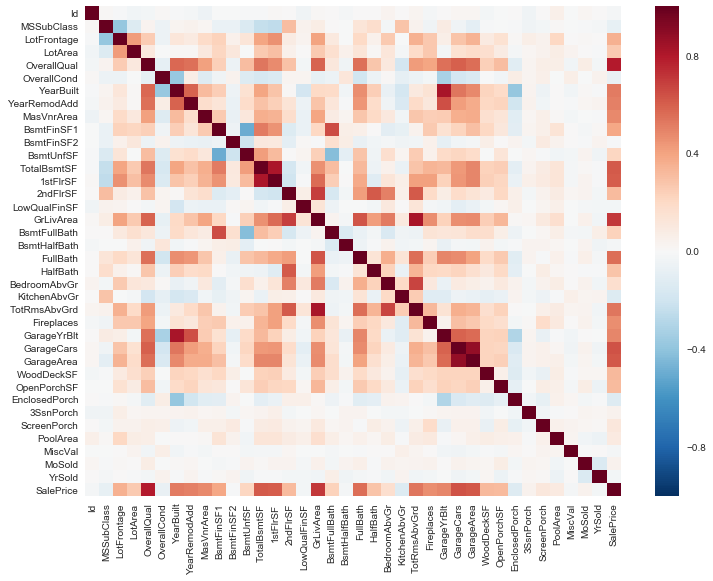

In [4]:
# Check numeric feature correlations using Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1.0, square=False)

It seems that the following numeric features are highly related to sale price:
OverallQual, TotalBsmtSF, 1stFlrSF, GrLivArea, Fullbath, TotRmsAbvGrd, GarageCars,GarageArea.
Create a zoomed heatmap to take a loser look at those vars.

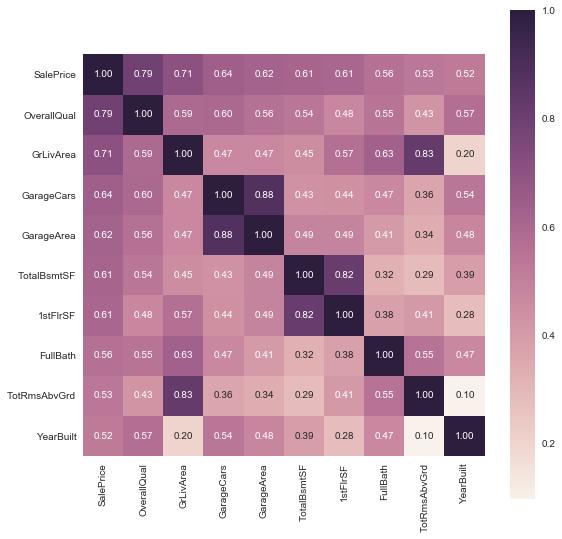

In [5]:
# Take a closer look at the important features with a zoomed Heatmap
k=10
top_cor_feats =corrmat['SalePrice'].nlargest(k).index
cm=np.corrcoef(train[top_cor_feats].values.T)
plt.figure(figsize=(9,9))
sns.heatmap(cm,cbar=True,annot= True,square=True,fmt='.2f',annot_kws={'size':10},xticklabels=top_cor_feats.values,\
            yticklabels=top_cor_feats.values)

Three pairs of features have the colinearity issue: GarageCars vs GarageArea, TotalBsmtSF vs 1stFlrSF, and GrLivArea vs TotRmsAbvGrd; Those are pretty analogous features. I would keep GarageCars, GrLivArea, and TotalBsmtSF since their correlation to SalePrice is slightly higher 

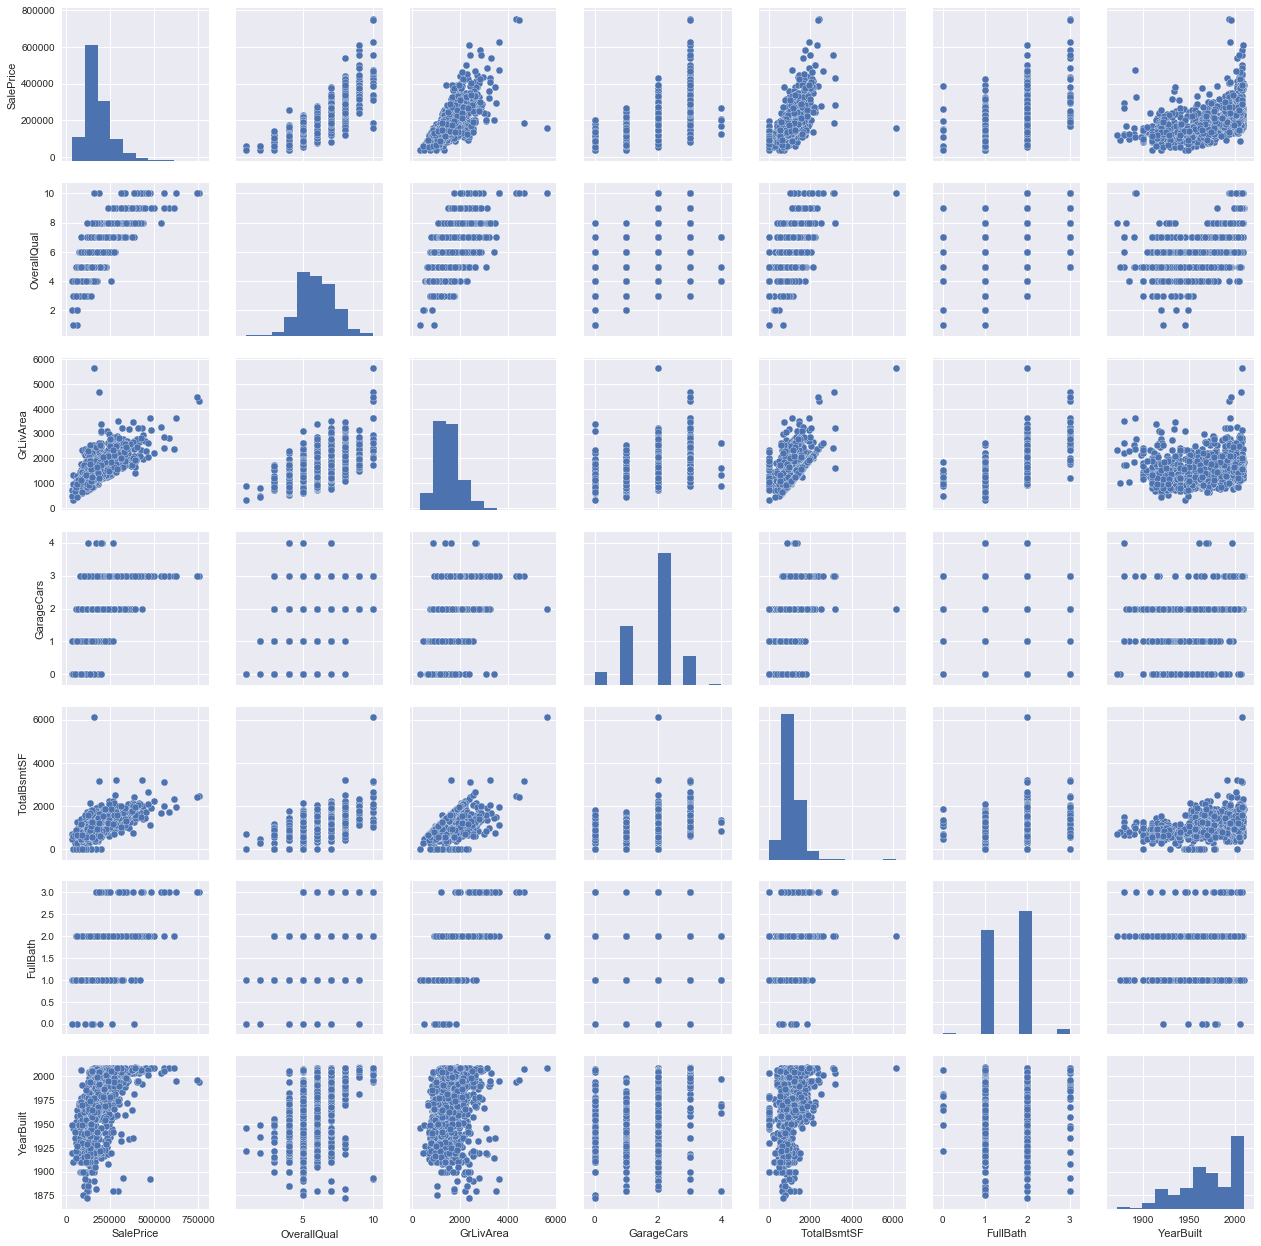

In [6]:
# Check the top covariants via pair plot
top_nums =["SalePrice","OverallQual","GrLivArea","GarageCars","TotalBsmtSF", "FullBath","YearBuilt"]
sns.pairplot(train[top_nums])

1) None of the features closes to normal distribution. Transformation is needed;
2) All features are positively correlated to sale price;
3) Some outliers can be found. For example, the dots representing extreme large living space in both GrLivArea and TotalBsmtSF

## Check out categorical features

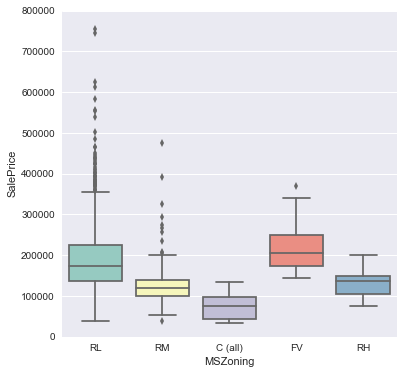

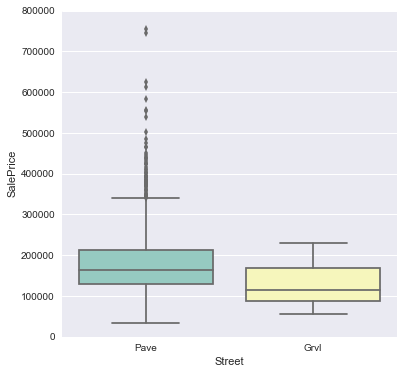

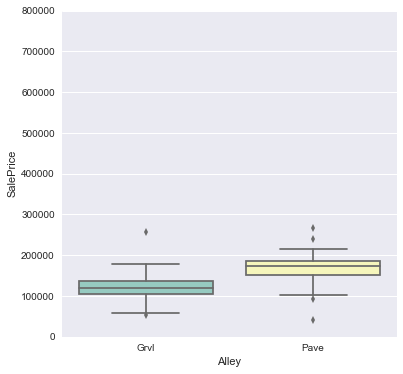

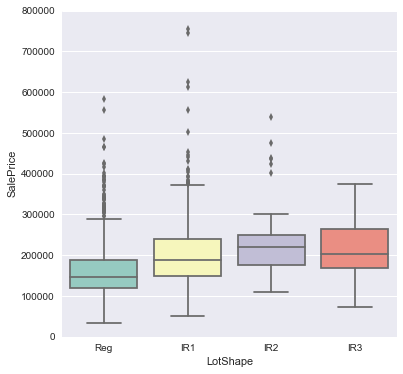

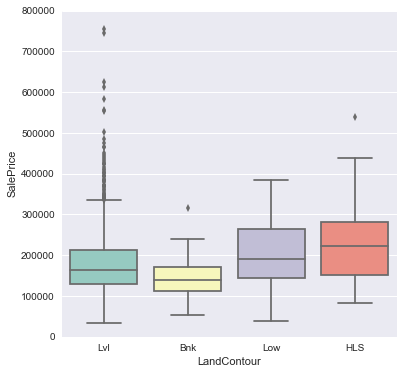

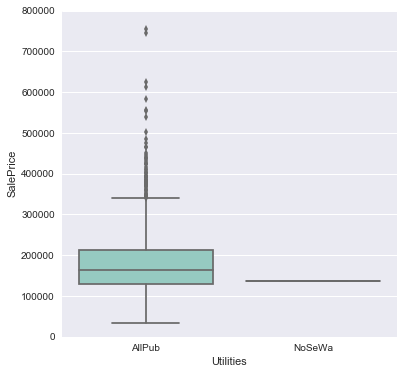

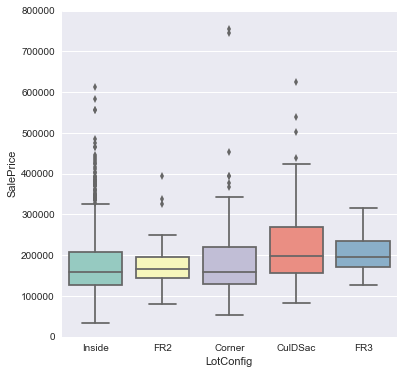

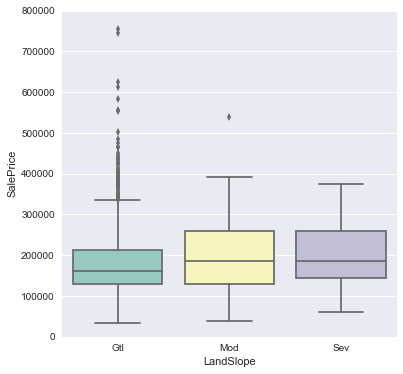

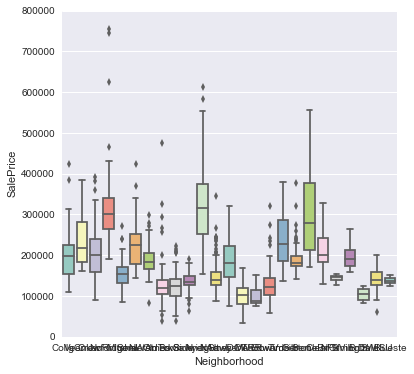

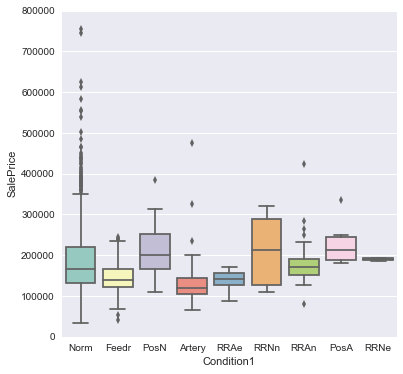

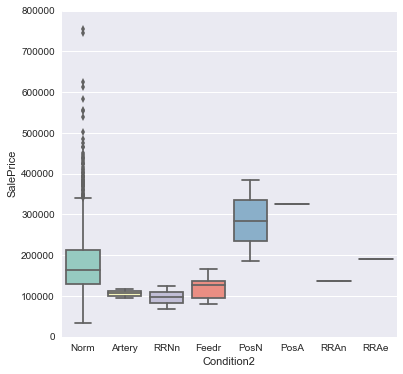

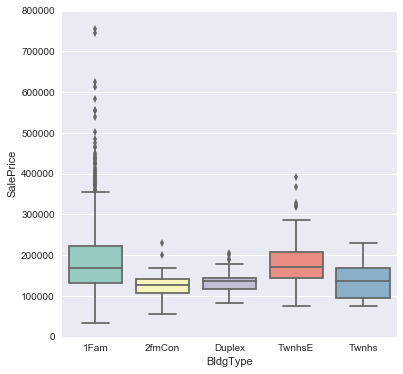

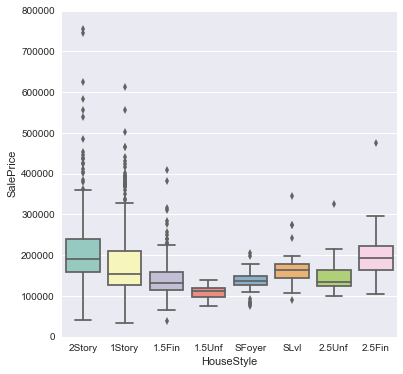

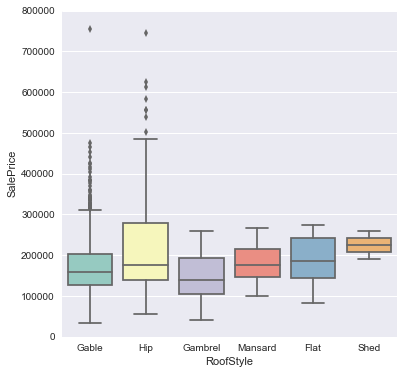

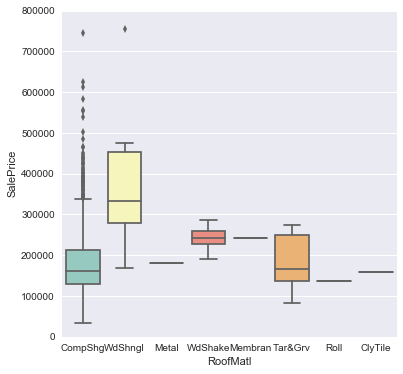

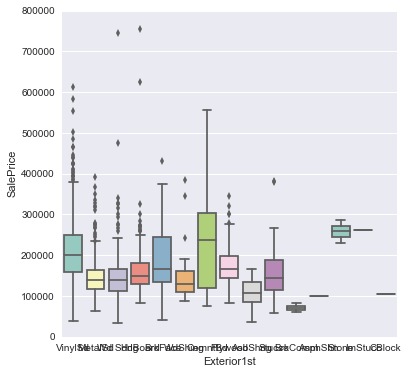

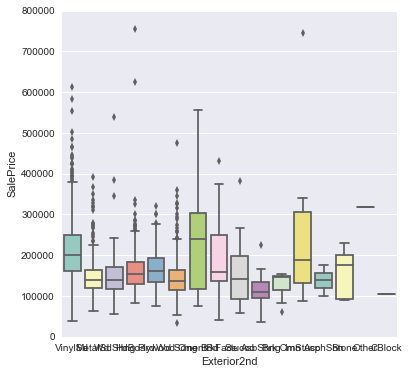

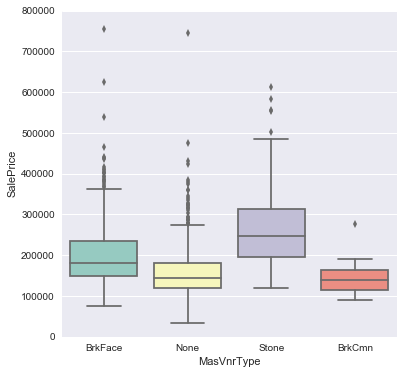

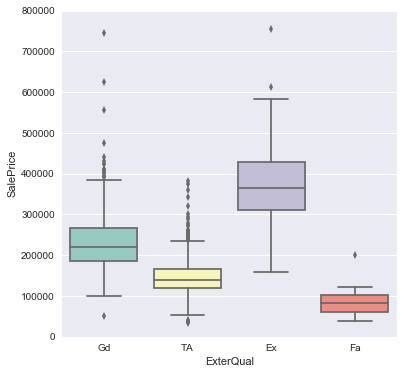

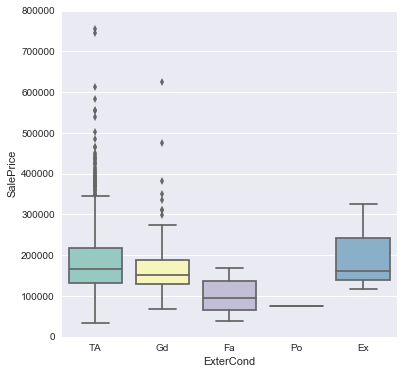

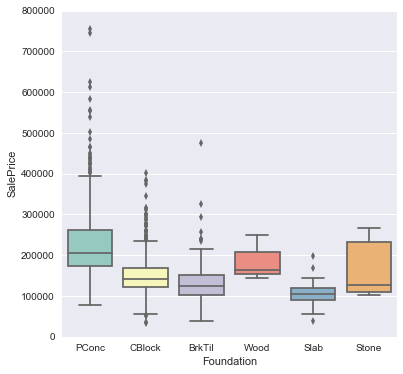

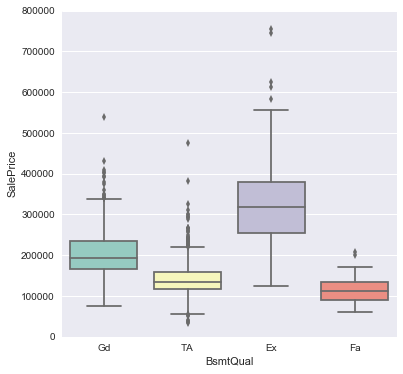

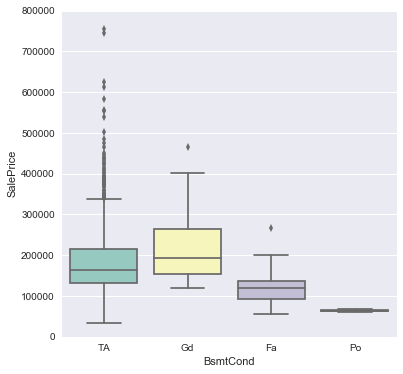

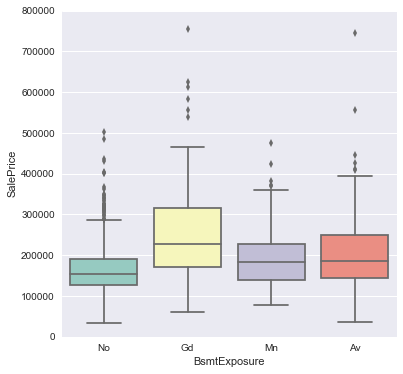

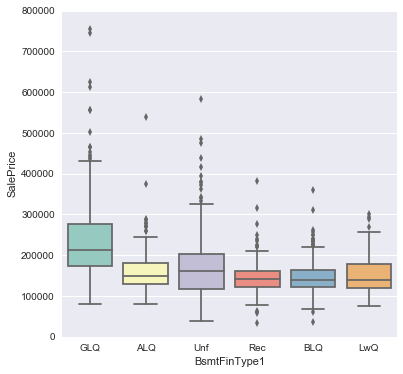

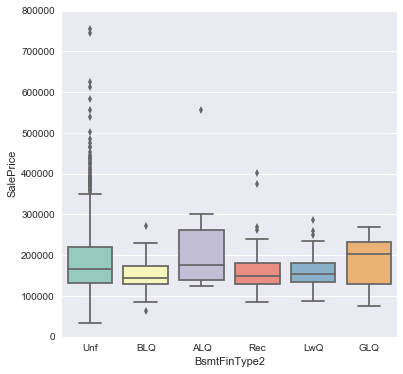

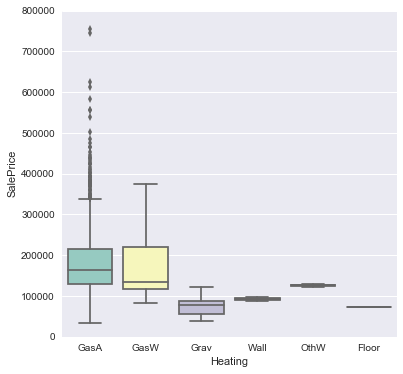

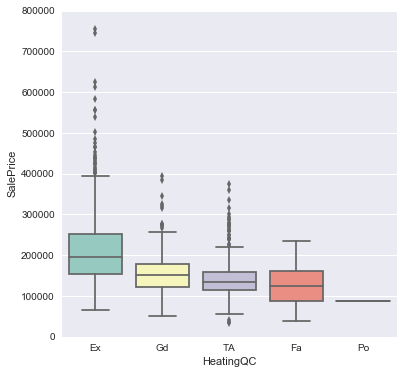

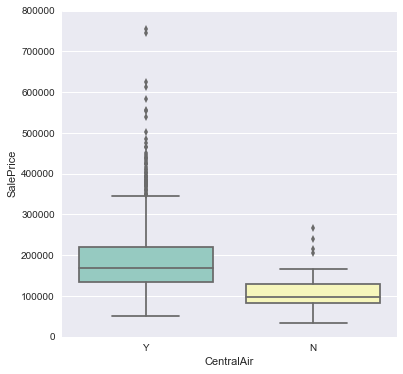

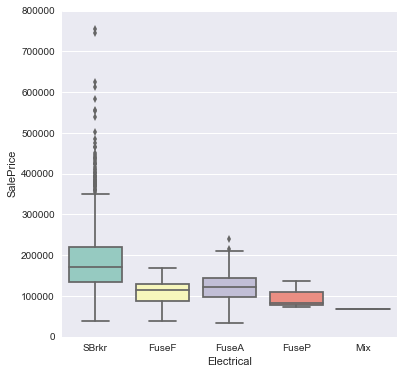

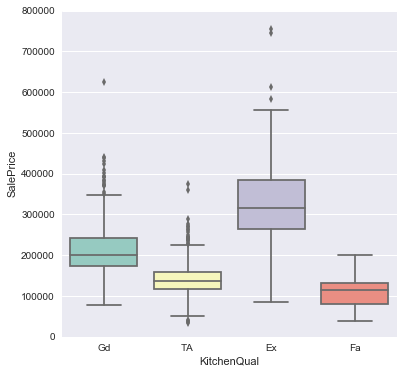

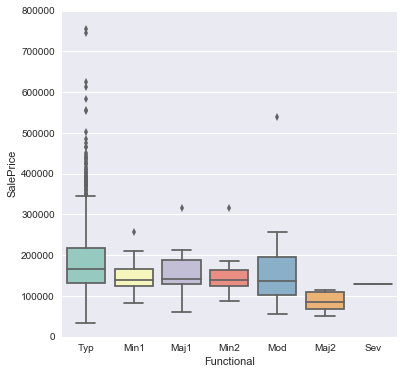

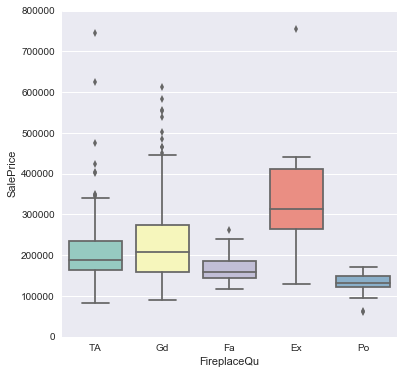

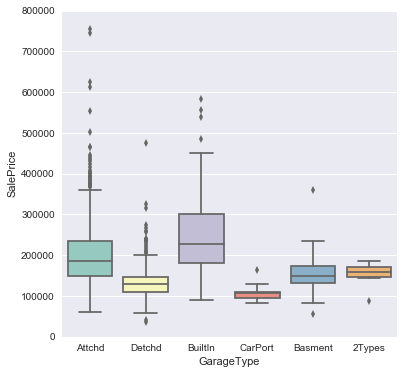

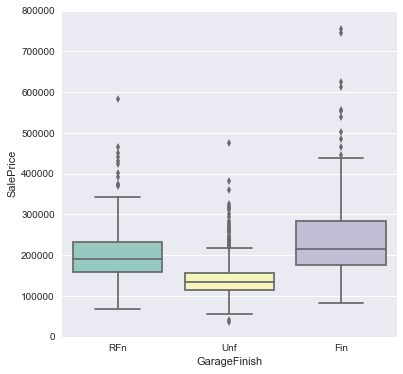

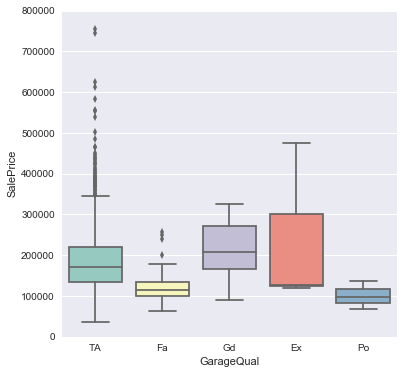

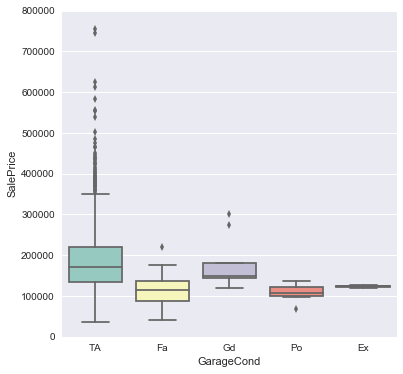

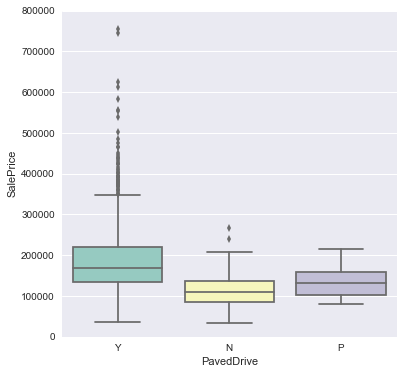

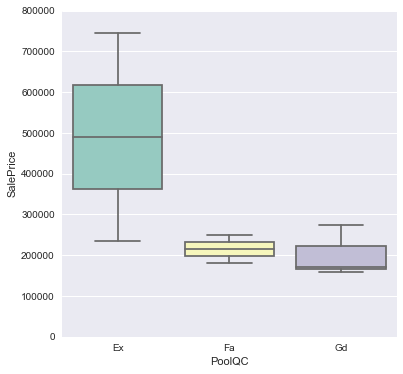

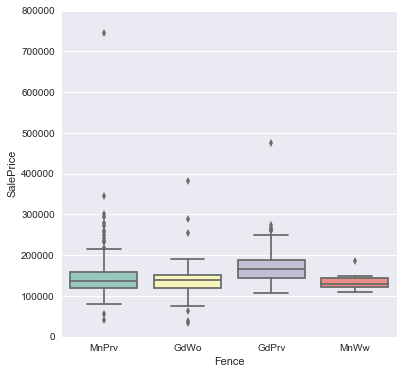

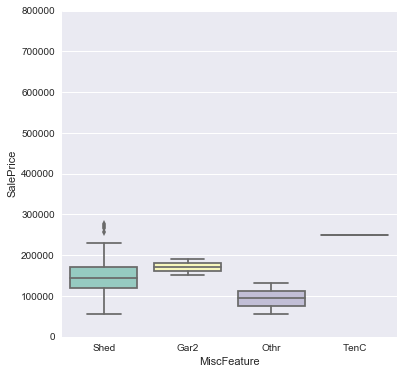

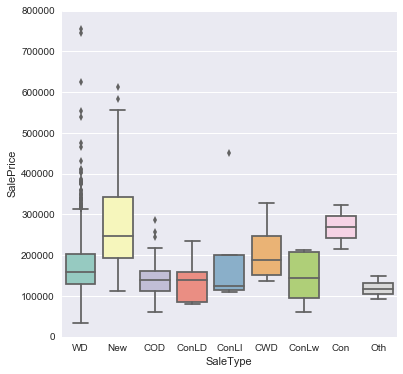

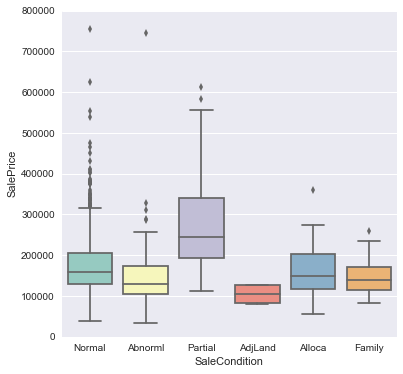

In [7]:
# Scan all categorical features in boxplot
cat_feats = train.select_dtypes(include=['object']).columns
for feature in cat_feats:
    f,ax=plt.subplots(figsize=(6,6))
    ax = sns.boxplot(x=feature, y="SalePrice",data=train,palette="Set3")
    ax.axis(ymin=0, ymax=800000)

Some categories seem to more diverse with respect to SalePrice than others.The following categorical vars are correlated to sale price, based on eyeball check on box plots: Neighborhood, Condition1, condition2, bldgType,HouseStyle, RoofMatl, Exterior1st,Exteior2nd,ExterQual,ExterCond, Foundation,BsmtQual,BsmtCond,BsmtFinType1,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,SaleType,SaleCondition

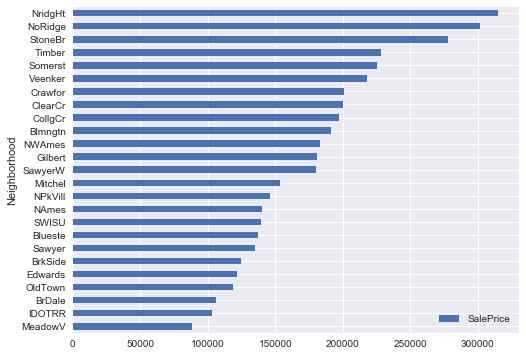

In [8]:
# Check sale price by neighborhood
NbhdPrice = train.groupby('Neighborhood')['SalePrice'].median().sort_values().reset_index()
NbhdPrice.plot(x='Neighborhood', y='SalePrice', kind = 'barh',figsize=(8,6))

ExpsvNbhds = NbhdPrice.loc[NbhdPrice['SalePrice'].nlargest(10).index]['Neighborhood']
CheapNbhds = NbhdPrice.loc[NbhdPrice['SalePrice'].nsmallest(10).index]['Neighborhood']

## Remove outliers

In [9]:
# Create a list of potential outliers to examine
potentials = pd.DataFrame()

# For important numeric features, find the data points with extreme high or low values with Tukey method
# Using a generous method here by setting distance as 3 instead of 1.5
for feature in top_cor_feats:
    Q1=np.nanpercentile(train[feature],25)
    Q3=np.nanpercentile(train[feature],75)
    IQR = Q3-Q1
    distance = [(Q1-x)/IQR if x<Q1 else (x-Q3)/IQR if x>Q3 else 0 for x in train[feature]]
    potentials = potentials.append(train.loc[pd.Series(distance)>3])

# Pick records identified as outlier for mutliple times
outliers = potentials.loc[potentials.duplicated(keep = False)]
outliers[top_cor_feats].sort_index()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt
440,555000,10,2402,3,672,3094,2402,2,10,2008
440,555000,10,2402,3,672,3094,2402,2,10,2008
496,430000,8,3228,2,546,3200,3228,3,10,1992
496,430000,8,3228,2,546,3200,3228,3,10,1992
523,184750,10,4676,3,884,3138,3138,3,11,2007
523,184750,10,4676,3,884,3138,3138,3,11,2007
523,184750,10,4676,3,884,3138,3138,3,11,2007
691,755000,10,4316,3,832,2444,2444,3,10,1994
691,755000,10,4316,3,832,2444,2444,3,10,1994
1182,745000,10,4476,3,813,2396,2411,3,10,1996


In [10]:
# Combine the eyeball test and the Tukey test to determine what records to remove
print(train.shape)
train = train.drop(train[train.index==523].index)
train = train.drop(train[train.index==1298].index)
train = train.drop(train[train.index==691].index)
train = train.drop(train[train.index==1182].index)
print(train.shape)

(1460, 81)
(1456, 81)


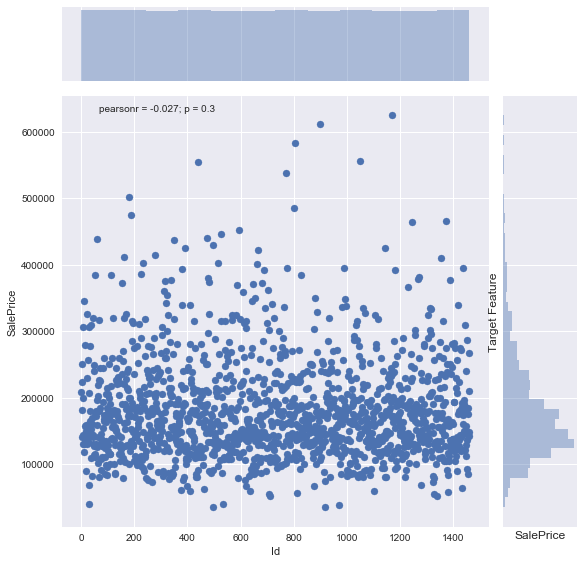

In [11]:
# Check Sale Price against Id. No meaningful pattern here, implying that Id doesn't contain any helpful information
plt.figure(figsize=(8,8))
sns.jointplot(x= 'Id', y= 'SalePrice', data= train,size=8)
plt.ylabel('Target Feature', fontsize=12)
plt.xlabel('SalePrice', fontsize=12)
plt.show()

## Check out the label

Skewness of the label is 1.565959


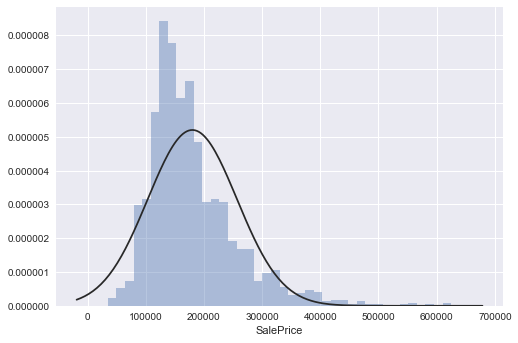

In [12]:
# The distribution of sale price deviates from the normal distribution and positively skewed
sns.distplot(train.SalePrice, fit=norm,kde = False)
print("Skewness of the label is %f" % train['SalePrice'].skew())

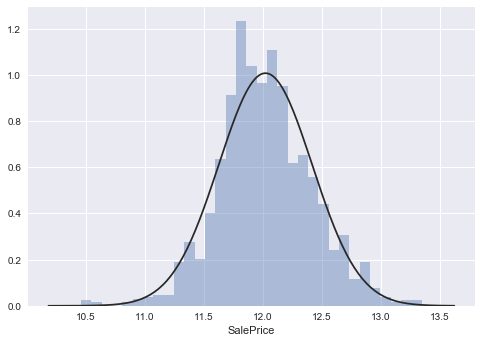

In [13]:
# Log transform the label
saleprice_transformed = np.log(train.SalePrice)
sns.distplot(saleprice_transformed,fit=norm,kde = False)
fig= plt.figure()

## Handle missing data

In [14]:
# Stack train and test dataframes
all_df= pd.concat([train,test],keys=("train","test"))
all_df =all_df.drop(["SalePrice"],axis=1)
print(all_df.shape)

(2915, 80)


In [15]:
# Check missing data
total = all_df.isnull().sum().sort_values(ascending=False)
pct = (all_df.isnull().sum()/all_df.isnull().count()).sort_values(ascending=False)
NAs = pd.concat([total, pct], axis=1, keys=['Total', 'Percent'])
NAs = NAs[NAs['Total']>=1]
NAs

,Total,Percent
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageQual,159,0.054545
GarageFinish,159,0.054545
GarageYrBlt,159,0.054545
GarageCond,159,0.054545


In [16]:
# Get freq tables in order to fill NAs
for col in NAs.index:
    print('------- Value Counts ------------------')
    print(all_df[col].value_counts())
    print('------- NA Counts ------------------')
    print(NAs.loc[col])

------- Value Counts ------------------
Ex    3
Gd    3
Fa    2
Name: PoolQC, dtype: int64
------- NA Counts ------------------
Total      2907.000000
Percent       0.997256
Name: PoolQC, dtype: float64
------- Value Counts ------------------
Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
------- NA Counts ------------------
Total      2810.000000
Percent       0.963979
Name: MiscFeature, dtype: float64
------- Value Counts ------------------
Grvl    120
Pave     78
Name: Alley, dtype: int64
------- NA Counts ------------------
Total      2717.000000
Percent       0.932075
Name: Alley, dtype: float64
------- Value Counts ------------------
MnPrv    328
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
------- NA Counts ------------------
Total      2345.00000
Percent       0.80446
Name: Fence, dtype: float64
------- Value Counts ------------------
Gd    742
TA    591
Fa     74
Po     46
Ex     42
Name: FireplaceQu, dtype: int64
------- NA Cou

In [17]:
# Impute NAs

# If confirmed no pool, fill with none; otherwise, fill with average QC
all_df.loc[(all_df['PoolArea']>0) & (all_df['PoolQC'].isnull()),'PoolQC'] = "TA"
all_df.loc[(all_df['PoolArea']==0) & (all_df['PoolQC'].isnull()),'PoolQC'] = "None"
    
# No miscellaneous feature
all_df['MiscFeature'].fillna('None',inplace=True)

# No alley access
all_df['Alley'].fillna('None',inplace=True)

# No fence
all_df['Fence'].fillna('None',inplace=True)

# No fireplace
all_df['FireplaceQu'].fillna('None',inplace=True)

# No garage
all_df['GarageQual'].fillna('None',inplace=True)
all_df['GarageFinish'].fillna('None',inplace=True)
all_df['GarageType'].fillna('None',inplace=True)
all_df['GarageCond'].fillna('None',inplace=True)
all_df['GarageArea'].fillna(0,inplace=True)
all_df['GarageCars'].fillna(0,inplace=True)
all_df['GarageYrBlt'].fillna(0,inplace=True)

# No basement
all_df['BsmtQual'].fillna('None',inplace=True)
all_df['BsmtCond'].fillna('None',inplace=True)
all_df['BsmtExposure'].fillna('None',inplace=True)
all_df['BsmtFinType1'].fillna('None',inplace=True)
all_df['BsmtFinSF1'].fillna(0,inplace=True)
all_df['BsmtFinType2'].fillna('None',inplace=True)
all_df['BsmtFinSF2'].fillna(0,inplace=True)
all_df['BsmtUnfSF'].fillna(0,inplace=True)
all_df['TotalBsmtSF'].fillna(0,inplace=True)
all_df['BsmtFullBath'].fillna(0,inplace=True)
all_df['BsmtHalfBath'].fillna(0,inplace=True)

# Masonry veneer - fill with the most common type - None
all_df['MasVnrType'].fillna('None',inplace=True)
all_df['MasVnrArea'].fillna(0,inplace=True)

# Utilities - fill with the most common type - AllPub
all_df['Utilities'].fillna('AllPub',inplace=True)

# Functional - fill with the most common type - Typ
all_df['Functional'].fillna('Typ',inplace=True)

# Electrical - fill with the most common type - SBrkr
all_df['Electrical'].fillna('SBrkr',inplace=True)

# KitchenQual - fill with the most common type - TA
all_df['KitchenQual'].fillna('TA',inplace=True)

# Exterior(1 missing) - fill with the most common type - VinylSd
all_df['Exterior1st'].fillna('VinylSd',inplace=True)
all_df['Exterior2nd'].fillna('VinylSd',inplace=True)

# SaleType(1 missing) - fill with the most common type - WD
all_df['SaleType'].fillna('WD',inplace=True)

# Check if all NAs are imputed
all_NAs = all_df.isnull().sum()
all_NAs = all_NAs[all_NAs>0]
print('Features with Missing Values are:', all_NAs.index.values)

Features with Missing Values are: ['LotFrontage' 'MSZoning']


In [18]:
# Two features left: LotFrontage and MSZoning. Didn't find an easy way to impute these two vars, do more exploration here

# LotFrontage: Linear feet of street connected to property (486 missing records) 
nolf = all_df[all_df['LotFrontage'].isnull()][['Id','LotFrontage','LotArea','Neighborhood']]
medianlf = all_df.groupby('Neighborhood')['LotFrontage'].median().reset_index()
medianlf.rename(columns = {'LotFrontage':'Nbhd_median_lf'}, inplace= True)
nolf = pd.merge(nolf,medianlf,how='left',on ='Neighborhood')
nolf['LotFrontage'].fillna((nolf['Nbhd_median_lf']),inplace=True)
all_df.loc[all_df['Id'].isin(nolf['Id']), ['LotFrontage']] = nolf['LotFrontage'].values


# MSZoning (4 missing records)
# Try to find the zoning code based on neighborhood
print(all_df[all_df.MSZoning.isnull()][['MSZoning','Neighborhood']])
print(all_df[all_df['Neighborhood']=='IDOTRR']['MSZoning'].value_counts())
print(all_df[all_df['Neighborhood']=='Mitchel']['MSZoning'].value_counts())

# Fill with the most common zoing code based on the neighborhood
all_df.loc[(all_df['MSZoning'].isnull()) & (all_df['Neighborhood']=='IDOTRR') , 'MSZoning'] = "RM"
all_df.loc[(all_df['MSZoning'].isnull()) & (all_df['Neighborhood']=='Mitchel'), 'MSZoning'] = "RL"

# Check if all NAs are imputed
all_NAs = all_df.isnull().sum()
all_NAs = all_NAs[all_NAs>0]
print('Features with Missing Values are:', all_NAs.index.values)

          MSZoning Neighborhood
test 455       NaN       IDOTRR
     756       NaN       IDOTRR
     790       NaN       IDOTRR
     1444      NaN      Mitchel
RM         68
C (all)    22
Name: MSZoning, dtype: int64
RL    104
RM      9
Name: MSZoning, dtype: int64
Features with Missing Values are: []


## Feature Engineering

In [19]:
# Split numerical features and categorical features
num_feats = all_df.select_dtypes(exclude=['object']).columns
cat_feats = all_df.select_dtypes(include=["object"]).columns
print("# of Numeric Features: %d" %len(num_feats))
print("# of Categorical Features: %d" %len(cat_feats))

# of Numeric Features: 37
# of Categorical Features: 43


In [20]:
# Convert some categorical variables to ordinal
qual_dict = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
all_df["GarageQual"] = all_df["GarageQual"].map(qual_dict).astype(int)
all_df["GarageCond"] = all_df["GarageCond"].map(qual_dict).astype(int)
all_df["BsmtQual"] = all_df["BsmtQual"].map(qual_dict).astype(int)
all_df["BsmtCond"] = all_df["BsmtCond"].map(qual_dict).astype(int)
all_df["PoolQC"] = all_df["PoolQC"].map(qual_dict).astype(int)
all_df["HeatingQC"] = all_df["HeatingQC"].map(qual_dict).astype(int)
all_df["KitchenQual"] = all_df["KitchenQual"].map(qual_dict).astype(int)
all_df["FireplaceQu"] = all_df["FireplaceQu"].map(qual_dict).astype(int)
all_df["ExterQual"] = all_df["ExterQual"].map(qual_dict).astype(int)
all_df["ExterCond"] = all_df["ExterCond"].map(qual_dict).astype(int)


all_df["BsmtExposure"] = all_df["BsmtExposure"].replace({"None":0,"No":1,"Mn":2,"Av":3,"Gd":4})
all_df["BsmtFinType1"] = all_df["BsmtFinType1"].replace({"None":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6})
all_df["BsmtFinType2"] = all_df["BsmtFinType2"].replace({"None":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6})
all_df["GarageFinish"] = all_df["GarageFinish"].replace({"None":0,"Unf":1,"RFn":2,"Fin":3})
all_df["Fence"] = all_df["Fence"].replace({"None":0,"MnWw":1,"GdWo":2,"MnPrv":3,"GdPrv":4})
all_df["Functional"] = all_df["Functional"].replace({"None":0,"Sal":1,"Sev":2,"Maj2":3,"Maj1":3,"Mod":4,
                                                     "Min1":5,"Min2":5,"Typ":6})

# Convert some numeric variables to categorical
# MSSubClass: Identifies the type of dwelling involved in the sale
all_df["MSSubClass"] = "MSSC" + all_df["MSSubClass"].astype(str)


In [21]:
# Create combined variables

# Overall quality of the house
all_df["OverallGrade"] = all_df["OverallQual"] * all_df["OverallCond"]
# Overall quality of the garage
all_df["GarageGrade"] = all_df["GarageQual"] * all_df["GarageCond"]
# Overall quality of the exterior
all_df["ExterGrade"] = all_df["ExterQual"] * all_df["ExterCond"]
# Overall kitchen score
all_df["KitchenScore"] = all_df["KitchenAbvGr"] * all_df["KitchenQual"]
# Overall fireplace score
all_df["FireplaceScore"] = all_df["Fireplaces"] * all_df["FireplaceQu"]
# Overall garage score
all_df["GarageScore"] = all_df["GarageArea"] * all_df["GarageQual"]
# Overall pool score
all_df["PoolScore"] = all_df["PoolArea"] * all_df["PoolQC"]
# Total number of bathrooms
all_df["TotalBath"] = all_df["BsmtFullBath"] + (0.5 * all_df["BsmtHalfBath"]) + \
                      all_df["FullBath"] + (0.5 * all_df["HalfBath"])
# Total SF for house (incl. basement)
all_df["AllSF"] = all_df["GrLivArea"] + all_df["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
all_df["AllFlrsSF"] = all_df["1stFlrSF"] + all_df["2ndFlrSF"]
# Total Finish SF for basement
all_df['AllFinBsmtSF'] = all_df['BsmtFinSF1'] + all_df['BsmtFinSF2']
all_df['PctFinBsmtSF'] = all_df['AllFinBsmtSF']/all_df['TotalBsmtSF']
all_df['PctFinBsmtSF'].fillna(0,inplace=True)
# Total SF for porch
all_df["AllPorchSF"] = all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + \
                       all_df["3SsnPorch"] + all_df["ScreenPorch"]

combined_feats = ["OverallGrade","GarageGrade","ExterGrade","KitchenScore","FireplaceScore",
                  "GarageScore","PoolScore","TotalBath","AllSF","AllFlrsSF","AllFinBsmtSF",
                  "PctFinBsmtSF","AllPorchSF"]
all_df[combined_feats].describe()

,OverallGrade,GarageGrade,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalBath,AllSF,AllFlrsSF,AllFinBsmtSF,PctFinBsmtSF,AllPorchSF
count,2915.00000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000
mean,33.71012,8.349228,10.482333,3.641166,2.053173,1407.153345,6.630875,2.215437,2544.290566,1491.562607,487.581132,0.436809,89.088851
std,9.16474,2.312605,2.170325,0.844998,2.322251,665.208514,118.745358,0.805396,774.254167,488.745499,465.447054,0.363911,107.749070
min,1.00000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,334.000000,334.000000,0.000000,0.000000,0.000000
25%,30.00000,9.000000,9.000000,3.000000,0.000000,936.000000,0.000000,1.500000,2004.000000,1120.000000,0.000000,0.000000,0.000000
50%,35.00000,9.000000,9.000000,4.000000,1.000000,1434.000000,0.000000,2.000000,2452.000000,1440.000000,456.000000,0.500000,50.000000
75%,40.00000,9.000000,12.000000,4.000000,4.000000,1728.000000,0.000000,2.500000,2993.000000,1740.000000,803.500000,0.761621,136.000000
max,90.00000,25.000000,25.000000,9.000000,15.000000,5392.000000,3200.000000,7.000000,10190.000000,5095.000000,4010.000000,1.000000,1207.000000


In [22]:
# Create a bunch of binary features

# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
all_df["Remodeled"] = (all_df["YearRemodAdd"] != all_df["YearBuilt"]) * 1

# Did a remodeling happen in the year the house was sold?
all_df["RecentRemodel"] = (all_df["YearRemodAdd"] == all_df["YrSold"]) * 1

# Has masonry veneer or not
all_df["HasMasVnr"] = all_df.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                 "Stone" : 1, "None" : 0})

# Was this house sold in the year it was built?
all_df["NewHouse"] = (all_df["SaleType"] == 'New') * 1

# House completed before sale or not
all_df["BoughtOffPlan"] = all_df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                        "Family" : 0, "Normal" : 0, "Partial" : 1})

new_cond_feats = ['Remodeled','RecentRemodel','HasMasVnr','NewHouse','BoughtOffPlan']
all_df[new_cond_feats].describe()

,Remodeled,RecentRemodel,HasMasVnr,NewHouse,BoughtOffPlan
count,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000
mean,0.465523,0.081304,0.394511,0.081304,0.083362
std,0.498896,0.273348,0.488829,0.273348,0.276476
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# Create Neightborhood level features
vars = ['LotArea','GrLivArea','OverallGrade','OverallQual','OverallCond','KitchenQual',\
        'ExterGrade','GarageGrade','TotalBath','AllSF','AllFlrsSF','AllPorchSF',\
        'YearBuilt','YearRemodAdd','TotalBsmtSF','BsmtUnfSF','Functional']
       
nbhd_vars = all_df.groupby('Neighborhood')[vars].median().reset_index()

cols = ['Neighborhood']+['{}_{}'.format('nbhd_median',v) for v in vars]
nbhd_vars.columns = cols
nbhd_feats = nbhd_vars.columns.values

all_df = pd.merge(all_df,nbhd_vars, how='left',on='Neighborhood')
all_df[nbhd_feats].head()

,Neighborhood,nbhd_median_LotArea,nbhd_median_GrLivArea,nbhd_median_OverallGrade,nbhd_median_OverallQual,nbhd_median_OverallCond,nbhd_median_KitchenQual,nbhd_median_ExterGrade,nbhd_median_GarageGrade,nbhd_median_TotalBath,nbhd_median_AllSF,nbhd_median_AllFlrsSF,nbhd_median_AllPorchSF,nbhd_median_YearBuilt,nbhd_median_YearRemodAdd,nbhd_median_TotalBsmtSF,nbhd_median_BsmtUnfSF,nbhd_median_Functional
0,CollgCr,9675.0,1504.0,35.0,7.0,5.0,4.0,12.0,9.0,2.5,2663.0,1504.0,43.0,2002.0,2002.0,1040.0,490.0,6.0
1,Veenker,14512.0,1706.5,40.0,7.5,5.0,4.0,12.0,9.0,2.5,3042.5,1706.5,95.0,1979.0,1985.5,1428.0,282.0,6.0
2,CollgCr,9675.0,1504.0,35.0,7.0,5.0,4.0,12.0,9.0,2.5,2663.0,1504.0,43.0,2002.0,2002.0,1040.0,490.0,6.0
3,Crawfor,11275.0,1648.0,40.0,6.0,6.0,3.0,9.0,9.0,2.0,2685.0,1648.0,115.0,1940.0,1986.0,918.0,536.0,6.0
4,NoRidge,11134.0,2417.0,40.0,8.0,5.0,4.0,12.0,9.0,3.5,3743.0,2417.0,84.0,1995.0,1996.0,1318.0,484.0,6.0


In [24]:
# Create features pertaining year and month

# Create year bins
# Binning can make the linear models more flexible by fiting a different line for each bin. 
# It won't imporve tree-based models, which can learn to split up data anywhere
year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
all_df["GarageYrBltBin"] = all_df.GarageYrBlt.map(year_map)
all_df["GarageYrBltBin"].fillna('None',inplace=True)
all_df['YrSoldBin'] = all_df.YrSold.map(year_map)
all_df['YearRemodAddBin'] = all_df.YearRemodAdd.map(year_map)

# Year position 
min_year = all_df['YearBuilt'].min()
max_year = all_df['YearBuilt'].max()
all_df['YearBuilt_pos']=all_df['YearBuilt'].apply(lambda x:np.float64((x-min_year+1))/(max_year-min_year+1))

# Create a hot season var
all_df.groupby('MoSold')['Id'].count()
all_df['HotSeason'] = all_df['MoSold'].replace({1:0,2:0,3:1,4:1,5:1,6:1,7:1,8:1,9:0,10:0,11:0,12:0})

year_feats = ['YearBuilt_pos',"GarageYrBltBin","YrSoldBin","YrSoldBin","HotSeason"]
all_df[year_feats].head()

,YearBuilt_pos,GarageYrBltBin,YrSoldBin,YrSoldBin,HotSeason
0,0.949640,YearBin7,YearBin7,YearBin7,0
1,0.755396,YearBin6,YearBin7,YearBin7,1
2,0.935252,YearBin7,YearBin7,YearBin7,0
3,0.316547,YearBin7,YearBin7,YearBin7,0
4,0.928058,YearBin7,YearBin7,YearBin7,0


In [25]:
# Create interaction and polynomial features

# Interaction and polynomials of all numeric features are first created and added to the Lasso model;
# The following features are selected based on the Lasso feature selection
feats = ["GrLivArea","YearBuilt","AllSF","KitchenQual","OverallQual","OverallGrade",\
         "nbhd_median_OverallGrade","Functional","YearRemodAdd","AllSF","GarageScore",\
         "LotArea","AllFlrsSF","HasMasVnr","TotalBath","OverallCond","GarageGrade",\
         "BsmtQual","ExterQual","Remodeled"] 

# Create polynomial features
poly_feats=[]
for feature in feats:
    all_df[feature+'2'] = all_df[feature]**2
    all_df[feature+'3'] = all_df[feature]**3
    poly_feats.append(feature+'2')
    poly_feats.append(feature+'3')    

    
# Create interactive features
import itertools
combo_feats= [] 
for combo in itertools.combinations(feats, 2):
    combo_name = combo[0] +'-'+ combo[1]
    all_df[combo_name] = all_df[combo[0]] * all_df[combo[1]]
    combo_feats.append(combo_name)


In [26]:
# Split numerical features and categorical features again
num_feats = all_df.select_dtypes(exclude=['object']).columns
cat_feats = all_df.select_dtypes(include=["object"]).columns
print("Numeric Features: %d" %len(num_feats))
print("Categorical Features: %d" %len(cat_feats))

Numeric Features: 305
Categorical Features: 31


In [27]:
# Log transform of the skewed numerical features to lessen impact of outliers
skewed_feats = all_df[num_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.50]
skewed_feats = skewed_feats.index
print("number of skewed features is %d" %(len(skewed_feats)))
all_df[skewed_feats] = np.log1p(all_df[skewed_feats])
all_df[skewed_feats].head()

number of skewed features is 188


,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,...,HasMasVnr-TotalBath,HasMasVnr-OverallCond,HasMasVnr-BsmtQual,HasMasVnr-ExterQual,HasMasVnr-Remodeled,TotalBath-OverallCond,TotalBath-BsmtQual,TotalBath-ExterQual,TotalBath-Remodeled,OverallCond-ExterQual
0,6.753438,6.751101,0.0,0.693147,6.561031,0.0,0.693147,0.693147,0.000000,5.017280,...,1.504077,1.791759,1.609438,1.609438,0.000000,2.917771,2.708050,2.708050,0.000000,3.044522
1,7.141245,0.000000,0.0,1.609438,6.886532,0.0,0.693147,0.000000,0.693147,5.652489,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.044522,2.397895,2.140066,0.000000,3.218876
2,6.825460,6.765039,0.0,1.098612,6.188264,0.0,0.693147,0.693147,0.000000,6.075346,...,1.504077,1.791759,1.609438,1.609438,0.693147,2.917771,2.708050,2.708050,1.504077,3.044522
3,6.869014,6.629363,0.0,0.693147,5.379897,0.0,0.693147,0.693147,0.000000,6.293419,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.397895,1.945910,1.945910,1.098612,2.772589
4,7.044033,6.960348,0.0,1.386294,6.486161,0.0,0.693147,0.693147,0.000000,6.196444,...,1.504077,1.791759,1.609438,1.609438,0.000000,2.917771,2.708050,2.708050,0.000000,3.044522


In [28]:
# Onehot encoding for categorical features
all_data = pd.get_dummies(all_df)

all_data = all_data.drop(["Id"],axis=1)
all_data.shape

(2915, 512)

## Modeling

In [29]:
# Split train and test
train_X = all_data.iloc[:train.shape[0]]
test_X = all_data.iloc[train.shape[0]:]
train_y = saleprice_transformed
train_Y = train_y.ravel()

print(train_X.shape)
print(test_X.shape)
print(len(train_y))

(1456, 512)
(1459, 512)
1456


In [30]:
# Standardize features
train_X = StandardScaler().fit_transform(train_X)
test_X = StandardScaler().fit_transform(test_X)

### PCA - Dimensionality Reduction

In [31]:
# pca = PCA(n_components=None)
# train_X_PCA = pca.fit_transform(train_X)
# test_X_PCA = pca.fit_transform(test_X)
# explained_variance = pca.explained_variance_ratio_
# np.cumsum(explained_variance)

In [32]:
# Splitting
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=0)

In [33]:
# Define model evaluation function
def cv_rmse_train(estimator):
    rmse= np.sqrt(-cross_val_score(estimator, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
def cv_rmse_test(estimator):
    rmse= np.sqrt(-cross_val_score(estimator, x_test, y_test, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### XGBoost Base Model for Feature Selection

In [34]:
# Use sklearn API here cuz it's easy to get feature importance
import xgboost as xgb
base = xgb.XGBRegressor(
                 colsample_bytree=0.8,
                 learning_rate=0.2,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=200,                                                                  
                 subsample=0.8,
                 seed=3)

base.fit(train_X,train_y)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(base).mean(),cv_rmse_train(base).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(base).mean(),cv_rmse_test(base).std()))

RMSE (Training data): 0.1200 +/- 0.0074
RMSE (Validation data): 0.1304 +/- 0.0151


XGB model: 323 features are picked and 189 features are dropped


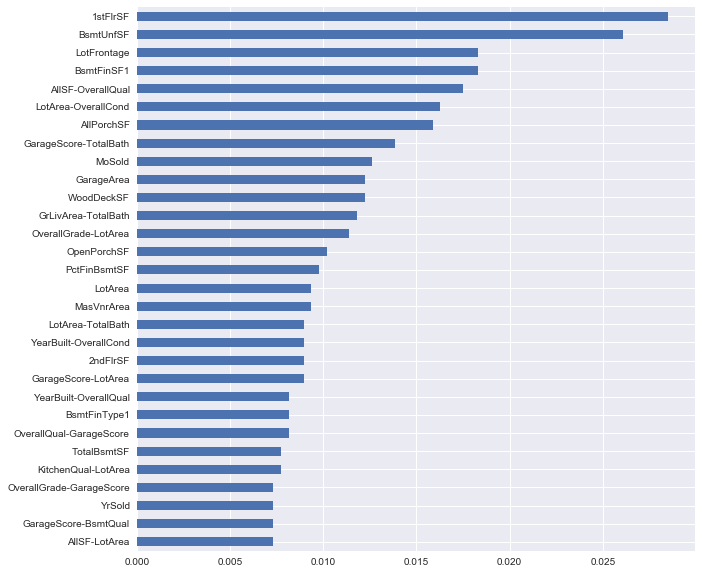

In [35]:
coefs = pd.Series(base.feature_importances_,index= all_data.columns)
print("XGB model: %s features are picked and %s features are dropped" % (sum(coefs != 0),sum(coefs == 0)))
imp_coefs = coefs.sort_values().tail(30)
imp_coefs.plot(kind = "barh",figsize=(10,10))

### Linear Regression with Ridge regularization (L2 penalty)

In [36]:
ridge_cv = RidgeCV(alphas = np.arange(0.1,1001,10)).fit(x_train, y_train)
rg_best_alpha =ridge_cv.alpha_
print("Best alpha :", rg_best_alpha)

Best alpha : 730.1


In [37]:
ridge = Ridge(alpha=rg_best_alpha).fit(x_train, y_train)
print("Final ridge model:")
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(ridge).mean(),cv_rmse_train(ridge).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(ridge).mean(),cv_rmse_test(ridge).std()))

Final ridge model:
RMSE (Training data): 0.1140 +/- 0.0061
RMSE (Validation data): 0.1123 +/- 0.0153


### Linear Regression with Lasso regularization (L1 penalty)

In [38]:
# Fit Lasso model
lasso_cv = LassoCV(alphas =np.arange(0.0005,0.01,0.001)).fit(x_train, y_train)
ls_best_alpha = lasso_cv.alpha_
print("Best alpha :", ls_best_alpha)

Best alpha : 0.0035


In [39]:
lasso =Lasso(alpha=ls_best_alpha).fit(x_train, y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(lasso).mean(),cv_rmse_train(lasso).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(lasso).mean(),cv_rmse_test(lasso).std()))

RMSE (Training data): 0.1142 +/- 0.0058
RMSE (Validation data): 0.1198 +/- 0.0094


Lasso model: 108 features are picked and 404 features are dropped


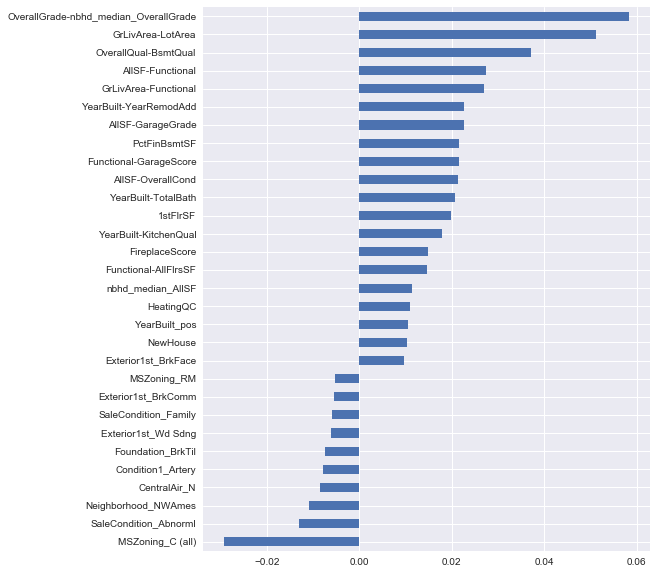

In [40]:
# # Plot important coefficients
coefs = pd.Series(lasso.coef_,index=all_data.columns)
print("Lasso model: %s features are picked and %s features are dropped" % (sum(coefs != 0),sum(coefs == 0)))
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(20)])
imp_coefs.plot(kind = "barh",figsize=(8,10))

### Elastic Net Model (L1 and L2 penalty)

Elastic Net is a compromise between Ridge and Lasso regression. It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso, such as the number of variables (Lasso can't select more features than it has observations, but it's not the case here anyway).

In [41]:
enet_cv = ElasticNetCV(alphas=np.arange(0.001,1,0.002), l1_ratio=(0.01,0.99,0.01)).fit(x_train, y_train)
en_best_alpha = enet_cv.alpha_
en_best_l1_ratio = enet_cv.l1_ratio_
print("Best alpha :", en_best_alpha)
print("Best L1 ratio :", en_best_l1_ratio)

Best alpha : 0.251
Best L1 ratio : 0.01


In [42]:
enet = ElasticNet(alpha=en_best_alpha,l1_ratio=en_best_l1_ratio).fit(x_train,y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(enet).mean(),cv_rmse_train(enet).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(enet).mean(),cv_rmse_test(enet).std()))

RMSE (Training data): 0.1134 +/- 0.0057
RMSE (Validation data): 0.1132 +/- 0.0117


Elastic Net model: 268 features are picked and 244 features are dropped


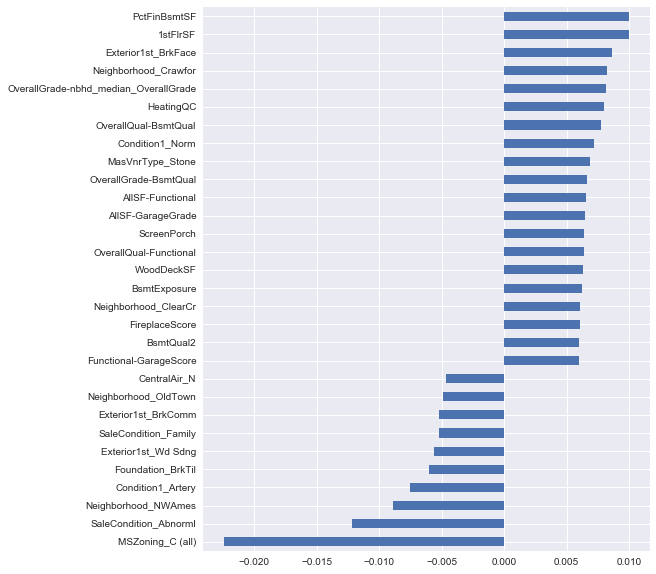

In [43]:
# Plot important coefficients
coefs = pd.Series(enet.coef_,index=all_data.columns)
print("Elastic Net model: %s features are picked and %s features are dropped" % (sum(coefs != 0),sum(coefs == 0)))
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(20)])
imp_coefs.plot(kind = "barh",figsize=(8,10))

### Support Vector Regression (SVR)

In [44]:
# from sklearn import svm
# svr = svm.SVR(C=1,kernel='rbf')
# svr.fit(train_X, train_y)
# print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(svr).mean(),cv_rmse_train(svr).std()))
# print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(svr).mean(),cv_rmse_test(svr).std()))

## Gradient Boosting

In [45]:
# Define paramater tuning function
def param_tuning(estimator, params_grid):
    starttime=time.time()
    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="neg_mean_squared_error", n_jobs= -1)
    model.fit(train_X,train_y)
    best_model = model.best_estimator_
    print("------------------------------")
    print(model.best_params_)
    print("RMSE (Training data): {}".format(np.sqrt(-model.best_score_)))
    print("------------------------------")
    print("Task running time: %.2f seconds" %(time.time()-starttime))
    return best_model

In [46]:
# GB baseline
gb0 = GradientBoostingRegressor(n_estimators = 200,learning_rate =0.1,random_state=0)
gb0.fit(train_X,train_y)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(gb0).mean(),cv_rmse_train(gb0).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(gb0).mean(),cv_rmse_test(gb0).std()))

RMSE (Training data): 0.1207 +/- 0.0070
RMSE (Validation data): 0.1277 +/- 0.0164


In [47]:
parameters = {'max_depth':np.arange(2,6,1),
              'max_features':np.arange(0.2,0.6,0.1),              
              'min_samples_split':np.arange(30,91,10),
              'min_samples_leaf':np.arange(2,11,2)
             }
gb1 = param_tuning(gb0,parameters)

------------------------------
{'min_samples_split': 80, 'max_features': 0.30000000000000004, 'min_samples_leaf': 4, 'max_depth': 2}
RMSE (Training data): 0.11605566277818034
------------------------------
Task running time: 2054.97 seconds


In [48]:
parameters = {'n_estimators':[300,500,1000,1500]}
gb = param_tuning(gb1,parameters)

------------------------------
{'n_estimators': 500}
RMSE (Training data): 0.11416623145434468
------------------------------
Task running time: 39.62 seconds


In [49]:
# Final GB model
gb.fit(train_X,train_y)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(gb).mean(),cv_rmse_train(gb).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(gb).mean(),cv_rmse_test(gb).std()))

RMSE (Training data): 0.1185 +/- 0.0065
RMSE (Validation data): 0.1259 +/- 0.0168


Gredient Boosting model: 259 features are picked and 253 features are dropped


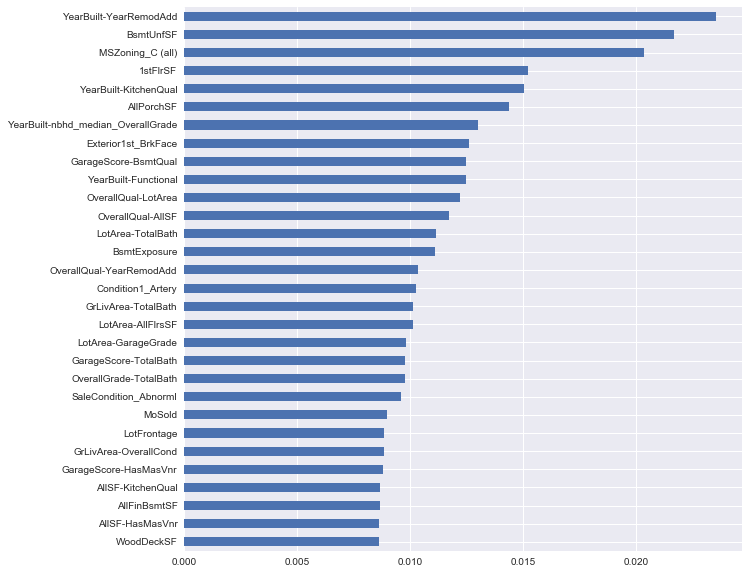

In [52]:
# Check feature importance
coefs = pd.Series(gb.feature_importances_,index= all_data.columns)
print("Gredient Boosting model: %s features are picked and %s features are dropped" % (sum(coefs != 0),sum(coefs == 0)))
imp_coefs = coefs.sort_values().tail(30)
imp_coefs.plot(kind = "barh",figsize=(10,10))

## XGBoost

In [53]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
xgtrain = xgb.DMatrix(train_X, label=train_Y)

start_time = time.time()
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['eta'] = 0.1
    params['max_depth'] = int(max_depth)   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = True    


    cv_result = xgb.cv(params, xgtrain,
                       num_boost_round=100000,
                       nfold=5,
                       metrics={'rmse'},
                       seed=3,
                       callbacks=[xgb.callback.early_stop(100)])

    return cv_result['test-rmse-mean'].min()


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (3, 13),
                              'min_child_weight': (0, 100),
                              'colsample_bytree': (0.2, 1),
                              'subsample': (0.3, 1),
                              'gamma': (0, 2)
                             }
                            )
xgb_BO.maximize(init_points=5, n_iter=30)

print('task running time: %d' %(time.time()-start_time))

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[580]	train-rmse:0.138322+0.00182262	test-rmse:0.147198+0.00981252

    1 | 00m47s |    0.14720 |             0.3198 |    1.3767 |      9.0789 |            42.3304 |      0.4447 | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[510]	train-rmse:0.139075+0.00215921	test-rmse:0.149812+0.0111269

    2 | 00m51s |    0.14981 |             0.2984 |    1.8328 |      8.4151 |            50.9832 |      0.7437 | 
Multiple eval metrics have been passed: 'test-rmse' will be

In [54]:
# Display tuning results
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=True)
xgb_BO_scores.head()

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
2,0.864624,0.058445,12.952089,69.670680,0.939073,0.119461
0,0.270971,0.242995,12.999164,99.996970,0.544370,0.132604
1,0.550089,1.493431,12.814129,0.120569,0.441467,0.146430
7,0.871053,1.953125,3.048076,45.139526,0.745603,0.152025
5,0.384407,1.978326,3.156859,12.288986,0.656561,0.152049


In [55]:
xgb_parameters=[]
for p in xgb_BO_scores.head(2).iterrows():
    xgb_parameters.append({
                  'max_depth':int(p[1].to_dict()['max_depth']),
                  'min_child_weight':int(p[1].to_dict()['min_child_weight']),
                  'colsample_bytree':p[1].to_dict()['colsample_bytree'],
                  'subsample':p[1].to_dict()['subsample'],
                  'gamma':p[1].to_dict()['gamma'],
                  'seed':3,
                  'nthread':-1        
                    })
xgb_parameters

[{'colsample_bytree': 0.8646236891961554,
  'gamma': 0.058445003673469165,
  'max_depth': 12,
  'min_child_weight': 69,
  'nthread': -1,
  'seed': 3,
  'subsample': 0.93907331691104834},
 {'colsample_bytree': 0.27097075524597991,
  'gamma': 0.24299517825243444,
  'max_depth': 12,
  'min_child_weight': 99,
  'nthread': -1,
  'seed': 3,
  'subsample': 0.54437001404889762}]

## Ensembling

In [56]:
NFOLDS = 5
SEED = 0

train_Y = train_y.ravel() # 1* matrix to *1 matrix (long to wide)
ntrain = len(train_X)
ntest = len(test_X)

# KFold from model selection package and cross validation package is different. This is from the cv package
kf = KFold(ntrain, n_folds = NFOLDS, shuffle=True, random_state=SEED)

In [57]:
class SklearnWrapper(object):
    
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed # add new attribute random_state in the params object
        self.clf = clf(**params) # set parameter in the classifier

    def train(self, train_X, train_Y):
        self.clf.fit(train_X, train_Y)

    def predict(self, x):
        return self.clf.predict(x)
    

In [58]:
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds',10000) 
        # pop(key, default) removes and returns last object or obj from the dictionary
        # if nrounds is specified in params, then remove it from the dictionary 
        # and pass it to the nrounds object with a default value

    def train(self, train_X, train_Y):
        dtrain = xgb.DMatrix(train_X, label=train_Y)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x): # x here should be np array
        return self.gbdt.predict(xgb.DMatrix(x))
    

In [59]:
def get_oof(clf): # get out of fold
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = train_X[train_index] # train folds
        y_tr = train_Y[train_index]
        x_te = train_X[test_index] # oof
        
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te) # oof train prediction
        oof_test_skf[i, :] = clf.predict(test_X) # test set prediction
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [60]:
ls_params={
    'alpha': ls_best_alpha
}

rg_params={
    'alpha': rg_best_alpha
}

en_params={
    'alpha': en_best_alpha,
    'l1_ratio': en_best_l1_ratio
}

gb_params = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'max_depth': 2,
    'max_features':0.3,
    'min_samples_split': 80,
    'min_samples_leaf': 4    
}


In [61]:
ls = SklearnWrapper(clf=Lasso, seed=SEED, params=ls_params)
rg = SklearnWrapper(clf=Ridge, seed=SEED, params=rg_params)
en = SklearnWrapper(clf=ElasticNet, seed=SEED, params=en_params)
gb = SklearnWrapper(clf=GradientBoostingRegressor, seed=SEED, params=gb_params)
xg = XgbWrapper(seed=SEED, params=xgb_parameters[0])
print(xgb_parameters[0])

{'gamma': 0.058445003673469165, 'nthread': -1, 'max_depth': 12, 'min_child_weight': 69, 'seed': 0, 'subsample': 0.93907331691104834, 'colsample_bytree': 0.8646236891961554}


In [62]:
import xgboost as xgb
start_time=time.time()

ls_oof_train, ls_oof_test = get_oof(ls)
rg_oof_train, rg_oof_test = get_oof(rg)
en_oof_train, en_oof_test = get_oof(en)
gb_oof_train, gb_oof_test = get_oof(gb)
xg_oof_train, xg_oof_test = get_oof(xg)

print('Time elapsed: %.2f seconds' %(time.time()-start_time))

Time elapsed: 2799.43 seconds


In [63]:
print("LS-CV: {}".format(np.sqrt(mean_squared_error(train_Y, ls_oof_train))))
print("RG-CV: {}".format(np.sqrt(mean_squared_error(train_Y, rg_oof_train))))
print("EN-CV: {}".format(np.sqrt(mean_squared_error(train_Y, en_oof_train))))
print("GB-CV: {}".format(np.sqrt(mean_squared_error(train_Y, gb_oof_train))))
print("XG-CV: {}".format(np.sqrt(mean_squared_error(train_Y, xg_oof_train))))

LS-CV: 0.11335294893848433
RG-CV: 0.11204648969178241
EN-CV: 0.11229919687944016
GB-CV: 0.11307935404692464
XG-CV: 0.1285615857591107


In [64]:
tr_X = np.concatenate((ls_oof_train,rg_oof_train,en_oof_train,gb_oof_train,xg_oof_train), axis=1)
te_X = np.concatenate((ls_oof_test,rg_oof_test,en_oof_test,gb_oof_test,xg_oof_test), axis=1)
print("{},{}".format(tr_X.shape, te_X.shape))

(1456, 5),(1459, 5)


### 2nd level model: Elastic Net

In [65]:
# 2nd level Elastic Net
enet_cv = ElasticNetCV(alphas=np.arange(0.001,1,0.002), l1_ratio=(0.01,0.99,0.005)).fit(tr_X, train_Y)
best_alpha = enet_cv.alpha_
best_l1_ratio = enet_cv.l1_ratio_
print("Best alpha :", best_alpha)
print("Best L1 ratio :", best_l1_ratio)

Best alpha : 0.001
Best L1 ratio : 0.99


In [66]:
enet = ElasticNet(alpha=best_alpha,l1_ratio=best_l1_ratio)
rmse= np.sqrt(-cross_val_score(enet, tr_X,train_Y, scoring="neg_mean_squared_error", cv = 5))
print('RMSE:',rmse.mean())

RMSE: 0.109301008087


In [67]:
enet = enet.fit(tr_X,train_Y)
enet_pred = np.exp(enet.predict(te_X))
enet_pred[:10]

array([ 127157.45731357,  163675.68712516,  181689.23519235,
        195839.01846387,  194209.1837189 ,  175681.77789402,
        179087.9522113 ,  167551.49678079,  192336.961692  ,
        122239.47294448])

### 2nd level model: XGBoost

In [68]:
dtrain = xgb.DMatrix(tr_X, label=train_Y)
dtest = xgb.DMatrix(te_X)

In [77]:
xgb_params = {
    'seed': 3,
    'learning_rate': 0.01,
    'max_depth':2,
    'min_child_weight': 1,    
    'colsample_bytree': 0.9, 
    'subsample': 0.8,  
    'gamma':0.1,
    'eval_metric': 'rmse',   
    'silent': 1,
}

In [78]:
res = xgb.cv(xgb_params, dtrain, num_boost_round=3000, nfold=NFOLDS, seed=SEED, stratified=False,
             early_stopping_rounds=25, verbose_eval=100, show_stdv=True)

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('best_nrounds: {}'.format(best_nrounds))
print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))

[0]	train-rmse:11.4136+0.00394145	test-rmse:11.4136+0.0158579
[100]	train-rmse:4.19243+0.00163028	test-rmse:4.1927+0.0136801
[200]	train-rmse:1.545+0.000530604	test-rmse:1.54563+0.00926513
[300]	train-rmse:0.57693+0.000402038	test-rmse:0.578985+0.00639613
[400]	train-rmse:0.23226+0.00105028	test-rmse:0.237665+0.00651335
[500]	train-rmse:0.125889+0.00199827	test-rmse:0.135533+0.00996432
[600]	train-rmse:0.102898+0.00244697	test-rmse:0.114712+0.011678
[700]	train-rmse:0.0991056+0.00248414	test-rmse:0.111595+0.0119961
[800]	train-rmse:0.0983054+0.00240951	test-rmse:0.111102+0.012027
[900]	train-rmse:0.097999+0.00237261	test-rmse:0.111003+0.0119807
best_nrounds: 895
Ensemble-CV: 0.11099860000000002+0.01197724226355967


In [80]:
gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
xgb_pred = np.exp(gbdt.predict(dtest))
xgb_pred[:10]

array([ 127921.0625  ,  164820.515625,  180034.625   ,  195055.953125,
        191149.015625,  170482.125   ,  173382.984375,  169204.3125  ,
        191343.4375  ,  122103.0625  ], dtype=float32)

In [81]:
final_label = 0.5 * enet_pred + 0.5 * xgb_pred

print(final_label[:10])
# pd.DataFrame({'Id': test.Id, 'SalePrice': final_label}).to_csv('.csv', index =False) 

[ 127539.25990678  164248.10137508  180861.93009618  195447.48579443
  192679.09967195  173081.95144701  176235.46829315  168377.90464039
  191840.199596    122171.26772224]
